In [45]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from glob import glob
import warnings
import cv2
import time
from skimage.color import rgb2gray

warnings.filterwarnings('ignore')
%matplotlib inline

import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn import metrics
from sklearn.decomposition import PCA

from sklearn.svm import SVC

In [2]:
from pathlib import Path

if os.name == 'nt':
    file_path = 'C:\\JL\\Master\\DSE_I2100_Applied Machine Learning and Data Mining\\Final_Project\\lgg-mri-segmentation'
else:
    file_path = os.path.join(os.path.expanduser("~"), "Downloads/")

## Comment below if using outside of collab
#file_path='/'

In [3]:
file_path

'/Users/juanguerrero/Downloads/'

In [4]:
# Set parameters
Size = (256, 256)
mask_files = glob(file_path + os.path.join('kaggle_3m','*','*_mask*'))
train_files = [file.replace('_mask', '') for file in mask_files]

In [5]:
def label(mask):
    value = np.max(imread(mask))
    return '1' if value > 0 else '0'
df = pd.DataFrame({"image": train_files,
                   "mask": mask_files,
                  "label":[label(x) for x in mask_files]})

In [6]:
df.shape

(3929, 3)

In [7]:
df.head()

,image,mask,label
0,/Users/juanguerrero/Downloads/kaggle_3m/TCGA_C...,/Users/juanguerrero/Downloads/kaggle_3m/TCGA_C...,0
1,/Users/juanguerrero/Downloads/kaggle_3m/TCGA_C...,/Users/juanguerrero/Downloads/kaggle_3m/TCGA_C...,0
2,/Users/juanguerrero/Downloads/kaggle_3m/TCGA_C...,/Users/juanguerrero/Downloads/kaggle_3m/TCGA_C...,0
3,/Users/juanguerrero/Downloads/kaggle_3m/TCGA_C...,/Users/juanguerrero/Downloads/kaggle_3m/TCGA_C...,0
4,/Users/juanguerrero/Downloads/kaggle_3m/TCGA_C...,/Users/juanguerrero/Downloads/kaggle_3m/TCGA_C...,0


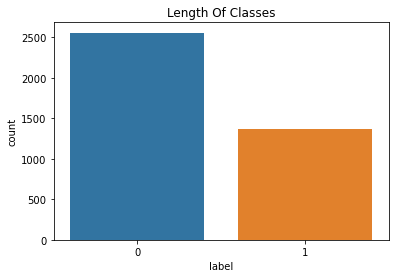

In [8]:
sns.countplot(data=df,x=df['label'])
plt.title('Length Of Classes')
plt.show()

In [9]:
from skimage.color import rgb2gray

image_dataset = []

for path in df["image"]:
  image_dataset.append(rgb2gray(cv2.imread(path)).reshape(-1))

image_dataset_np = np.array(image_dataset)


image_df = pd.DataFrame(image_dataset_np)

In [10]:
image_df.head()

,0,1,2,3,4,5,6,7,8,9,...,65526,65527,65528,65529,65530,65531,65532,65533,65534,65535
0,0.003639,0.003639,0.003639,0.003639,0.003639,0.003639,0.003639,0.003639,0.003639,0.003639,...,0.000833,0.000833,0.000833,0.000833,0.000833,0.000833,0.000833,0.000833,0.000833,0.000833
1,0.003639,0.003639,0.003639,0.003639,0.003639,0.003639,0.003639,0.003639,0.003639,0.003639,...,0.000833,0.000833,0.000833,0.000833,0.000833,0.000833,0.000833,0.000833,0.000833,0.000833
2,0.003639,0.003639,0.003639,0.003639,0.003639,0.003922,0.003922,0.003922,0.003922,0.003922,...,0.000833,0.000833,0.000833,0.000833,0.000833,0.000833,0.000833,0.000833,0.000833,0.000833
3,0.003639,0.003639,0.003639,0.003639,0.003639,0.003639,0.003639,0.003639,0.003639,0.003639,...,0.000833,0.000833,0.000833,0.000833,0.000833,0.000833,0.000833,0.000833,0.000833,0.000833
4,0.003639,0.003639,0.003639,0.003639,0.003639,0.003639,0.003639,0.003639,0.003639,0.003639,...,0.000833,0.000833,0.000833,0.000833,0.000833,0.000833,0.000833,0.000833,0.000833,0.000833


In [11]:
from sklearn.model_selection import train_test_split

X = image_df
y = df.label

print(X.shape)
print(y.shape)
 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


(3929, 65536)
(3929,)


### Run a Random Forest classifier without any image pre-processing

#### Initialize and train

In [14]:
start = time.time()
clf = RandomForestClassifier(n_estimators=300 ,random_state=0)
clf.fit(X_train, y_train)
end = time.time()
print('Total time to initialize and train the classifier: ', end-start, 'seconds')

Total time to initialize and train the classifier:  95.74980616569519 seconds


#### Predict

In [15]:
start = time.time()
ytest_pred = clf.predict(X_test)
end = time.time()
print('Total time to make a prediction on the test dataset: ', end-start, 'seconds')

Total time to make a prediction on the test dataset:  0.9115760326385498 seconds


### Image Compression using PCA

We will use PCA to choose the right number of dimensions (i.e the right number of principal components)

In [17]:
pca = PCA()

In [18]:
pca.fit(image_df)

PCA()

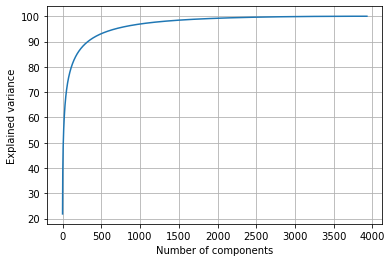

In [19]:
plt.grid()
plt.plot(np.cumsum(pca.explained_variance_ratio_*100))
plt.xlabel('Number of components')
plt.ylabel('Explained variance')
plt.show()

#### PCA with 10 components

Lets try out the first 10 components to compress the image. As you may notice, the first 10 components might not capture all of the variability from the original data thus genreating a blurry image.

In [20]:
pca_10 = PCA(n_components=10)
pca_reduced_10 = pca_10.fit_transform(image_df)
pca_recovered_10 = pca_10.inverse_transform(pca_reduced_10)

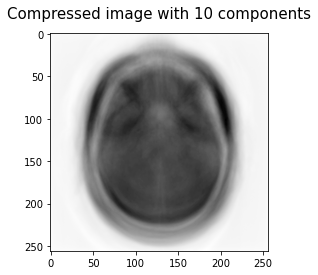

In [21]:
img_pca_10 = pca_recovered_10[1,:].reshape([256,256])
plt.imshow(img_pca_10, cmap='gray_r')
plt.title('Compressed image with 10 components', fontsize=15, pad=15)
plt.show()

#### PCA with 1000 components 

Next lets try 1000 components and view the image to see if the clarity increased

In [22]:
pca_1000 = PCA(n_components=1000)
pca_reduced_1000 = pca_1000.fit_transform(image_df)
pca_recovered_1000 = pca_1000.inverse_transform(pca_reduced_1000)

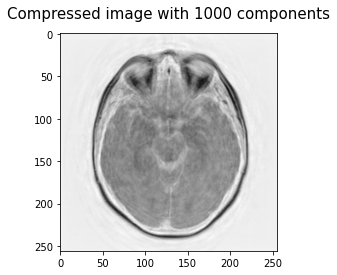

In [23]:
img_pca_1000 = pca_recovered_1000[1,:].reshape([256,256])
plt.imshow(img_pca_1000, cmap='gray_r')
plt.title('Compressed image with 1000 components', fontsize=15, pad=15)
plt.show()

#### PCA with 90% of the components

It seems that we can get away with using the number of components that yield 90% of the overall variability. This number is exactly 329 components

In [24]:
pca_90_percent = PCA(n_components=.9)
pca_reduced_90_percent = pca_90_percent.fit_transform(image_df)
pca_recovered_90_percent = pca_90_percent.inverse_transform(pca_reduced_90_percent)

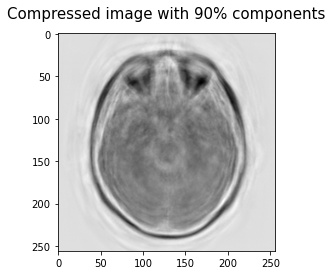

In [25]:
pca_90_percent_img = pca_recovered_90_percent[1,:].reshape([256,256])
plt.imshow(pca_90_percent_img, cmap='gray_r')
plt.title('Compressed image with 90% components', fontsize=15, pad=15)
plt.show()

In [26]:
pca_reduced_90_percent.shape

(3929, 329)

In [27]:
## Re-assign the X value and re-run a train-test split

X = pca_reduced_90_percent

## Check the shape
print(X.shape)
 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

(3929, 329)


#### Re run the Random Forest Classifier and read its performance

##### Initialize and train

In [47]:
start = time.time()
clf = RandomForestClassifier(n_estimators=300 ,random_state=0)
clf.fit(X_train, y_train)
end = time.time()
print('Total time to initialize and train the classifier: ', end-start, 'seconds')

Total time to initialize and train the classifier:  6.66703987121582 seconds


##### Predict

In [48]:
start = time.time()
ytest_pred = clf.predict(X_test)
end = time.time()
print('Total time to make a prediction on the test dataset: ', end-start, 'seconds')

Total time to make a prediction on the test dataset:  0.07030105590820312 seconds


In [49]:
print ("Accuracy RF= ", metrics.accuracy_score(y_test,ytest_pred))

Accuracy RF=  0.843484965304549


In [61]:
print('              =======Classification Report RF========')
print('')
print (metrics.classification_report(y_test,ytest_pred))

              =======Classification Report RF========

              precision    recall  f1-score   support

           0       0.82      0.98      0.89       852
           1       0.94      0.58      0.72       445

    accuracy                           0.84      1297
   macro avg       0.88      0.78      0.80      1297
weighted avg       0.86      0.84      0.83      1297



In [51]:
cm = confusion_matrix(y_test,ytest_pred)

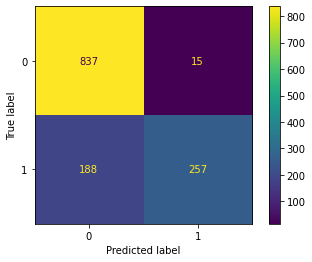

In [52]:
cm_display = ConfusionMatrixDisplay(cm).plot()

### Lets now run a support vector machine classifier

#### Initialize and train

In [62]:
start = time.time()
SVM = SVC(kernel='rbf')
SVM.fit(X_train,y_train)
end = time.time()
print('Total time to initialize and train the classifier: ', end-start, 'seconds')

Total time to initialize and train the classifier:  0.5572559833526611 seconds


#### Predict

In [63]:
start = time.time()
ytest_pred = SVM.predict(X_test)
end = time.time()
print('Total time to make a prediction on the test dataset: ', end-start, 'seconds')

Total time to make a prediction on the test dataset:  0.41004276275634766 seconds


In [64]:
print ("Accuracy SVM= ", metrics.accuracy_score(y_test,ytest_pred))

Accuracy SVM=  0.8797224363916731


In [65]:
print('              =======Classification Report SVM========')
print('')
print (metrics.classification_report(y_test,ytest_pred))

              =======Classification Report SVM========

              precision    recall  f1-score   support

           0       0.90      0.92      0.91       852
           1       0.84      0.81      0.82       445

    accuracy                           0.88      1297
   macro avg       0.87      0.86      0.87      1297
weighted avg       0.88      0.88      0.88      1297



In [66]:
cm = confusion_matrix(y_test,ytest_pred)

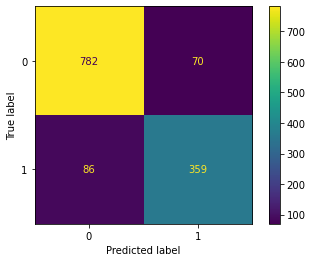

In [67]:
cm_display = ConfusionMatrixDisplay(cm).plot()

### TODO's
- Research what other EDA techniques we can apply to the images
- Apply some sort of Visualization.
- Data Augmentation to balance images (Check for class imbalance)


### Resources
- [EDA for Image Classification](https://medium.com/geekculture/eda-for-image-classification-dcada9f2567a)
- [How to Do Data Exploration for Image Segmentation and Object Detection (Things I Had to Learn the Hard Way) | Neptune Blog](https://neptune.ai/blog/data-exploration-for-image-segmentation-and-object-detection)
- [Exploratory Data Analysis Ideas for Image Classification](https://towardsdatascience.com/exploratory-data-analysis-ideas-for-image-classification-d3fc6bbfb2d2)
- [4 Ways to Improve Class Imbalance for Image Data](https://towardsdatascience.com/4-ways-to-improve-class-imbalance-for-image-data-9adec8f390f1)



### Videos
- [Image classification using traditional machine learning](https://www.youtube.com/watch?v=nK-2k_ENgEc)
- [Working with imbalanced data during machine learning training](https://www.youtube.com/watch?v=kus4kmDhfdM)
- [Feature selection for speeding up machine learning training​](https://www.youtube.com/watch?v=xvmtpWGBLjI&list=PLHae9ggVvqPgyRQQOtENr6hK0m1UquGaG&index=93)
- [Deep Learning terminology explained - Data augmentation](https://www.youtube.com/watch?v=_bahDWWufCc&list=PLHae9ggVvqPgyRQQOtENr6hK0m1UquGaG&index=107)
- [Binary Classification using Deep Learning](https://www.youtube.com/watch?v=L-flsWk692E&list=PLHae9ggVvqPgyRQQOtENr6hK0m1UquGaG&index=114)
- [Binary semantic segmentation using U-Net (in Keras)](https://www.youtube.com/watch?v=oBIkr7CAE6g&list=PLHae9ggVvqPgyRQQOtENr6hK0m1UquGaG&index=122)

## Feature Selection

## Classification

### Evaluation and Conclusion

## Segmentation

### Evaluation and Conclusion